# Fraud Detection in Python 3-4

## Fraud detection using unlabelled data

### Exploring your data

In [10]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

In [55]:
df = pd.read_csv('chapter_3/banksim.csv')
df.head()

,Unnamed: 0,age,gender,category,amount,fraud
0,171915,3,F,es_transportation,49.71,0
1,426989,4,F,es_health,39.29,0
2,310539,3,F,es_transportation,18.76,0
3,215216,4,M,es_transportation,13.95,0
4,569244,2,M,es_transportation,49.87,0


In [56]:
df.shape

(7200, 6)

In [4]:
df.groupby('category').mean()

,Unnamed: 0,amount,fraud
category,,,
es_barsandrestaurants,267372.707865,43.841793,0.022472
es_contents,335906.153846,55.170000,0.000000
es_fashion,286952.226804,59.780769,0.020619
es_food,334978.976190,35.216050,0.000000
es_health,335355.176955,126.604704,0.242798
es_home,248312.583333,120.688317,0.208333
es_hotelservices,280138.548387,172.756245,0.548387
es_hyper,244440.712500,46.788180,0.125000
es_leisure,186541.307692,229.757600,1.000000


you can see from the category averages that fraud is more prevalent in these categories

### Customer segmentation

In [7]:
# Group by age groups and get the mean
df.groupby('age').mean()

,Unnamed: 0,amount,fraud
age,,,
0,327520.450000,49.468935,0.050000
1,290985.509116,35.622829,0.026648
2,296867.958851,37.228665,0.028718
3,291471.417346,37.279338,0.023283
4,306041.396403,36.197985,0.035966
5,290885.960859,37.547521,0.023990
6,299193.716561,36.700852,0.022293
U,288372.181818,39.117000,0.000000


In [8]:
# Count the values of the observations in each age group
df['age'].value_counts()

2    2333
3    1718
4    1279
5     792
1     713
6     314
0      40
U      11
Name: age, dtype: int64

you can see the average amount spent as well as fraud occurrence is rather similar across groups. Age group '0' stands out but since there are only 40 cases, it does not make sense to split these out in a separate group and run a separate model on them.

### Using statistics to define normal behavior

This gives you an idea of how fraudulent transactions differ structurally from normal transactions.

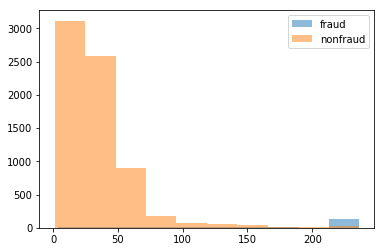

In [12]:
# Create two dataframes with fraud and non-fraud data 
df_fraud = df.loc[df.fraud == 1] 
df_non_fraud = df.loc[df.fraud == 0]

# Plot histograms of the amounts in fraud and non-fraud data 
plt.hist(df_fraud.amount, alpha=0.5, label='fraud')
plt.hist(df_non_fraud.amount, alpha=0.5, label='nonfraud')
plt.legend();

As the number fraud observations is much smaller, it is difficult to see the full distribution. Nonetheless, you can see that the fraudulent transactions tend to be on the larger side relative to normal obervations. This is good news, as it helps us later in detecting fraud from non-fraud.

### Scaling the data

In [57]:
df.drop('Unnamed: 0', axis=1, inplace=True)

In [58]:
df.head()

,age,gender,category,amount,fraud
0,3,F,es_transportation,49.71,0
1,4,F,es_health,39.29,0
2,3,F,es_transportation,18.76,0
3,4,M,es_transportation,13.95,0
4,2,M,es_transportation,49.87,0


In [59]:
df.gender.value_counts()

F    3972
M    3212
E      11
U       5
Name: gender, dtype: int64

In [60]:
df = df.drop(df[(df.gender == "E") | (df.gender == "U")].index)

In [61]:
df.gender.unique()

array(['F', 'M'], dtype=object)

In [62]:
from sklearn.preprocessing import LabelEncoder ###################################

le = LabelEncoder()
gender = le.fit_transform(df.gender)

In [63]:
df['M'] = pd.get_dummies(df.gender)['M']

In [64]:
df = pd.concat([df,pd.get_dummies(df.category, drop_first=True)],axis=1)

In [65]:
y = df.fraud.copy()

In [66]:
df.drop(['gender', 'fraud', 'category'], axis=1, inplace=True)

In [67]:
df.head()

,age,amount,M,es_contents,es_fashion,es_food,es_health,es_home,es_hotelservices,es_hyper,es_leisure,es_otherservices,es_sportsandtoys,es_tech,es_transportation,es_travel,es_wellnessandbeauty
0,3,49.71,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,4,39.29,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,3,18.76,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,4,13.95,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,2,49.87,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [68]:
df.shape

(7184, 17)

In [69]:
y.shape

(7184,)

In [51]:
# Import the scaler
from sklearn.preprocessing import MinMaxScaler

# Transform df into a numpy array
X = np.array(df).astype(np.float)

# Define the scaler and apply to the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X) ###################################

In [52]:
X_scaled.shape

(7184, 17)

### K-means clustering

In [53]:
# Import MiniBatchKmeans 
from sklearn.cluster import MiniBatchKMeans ###################################

# Define the model 
kmeans = MiniBatchKMeans(n_clusters=8, random_state=0)

# Fit the model to the scaled data
kmeans.fit(X_scaled)

MiniBatchKMeans(batch_size=100, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=8,
        n_init=3, random_state=0, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

### Elbow method

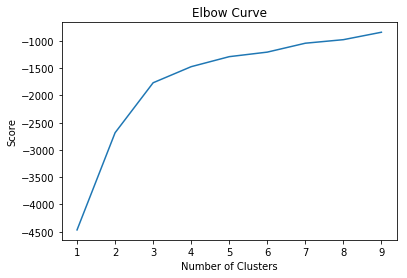

In [54]:
# Define the range of clusters to try
clustno = range(1, 10)

# Run MiniBatch Kmeans over the number of clusters
kmeans = [MiniBatchKMeans(n_clusters=i) for i in clustno] ###################################

# Obtain the score for each model
score = [kmeans[i].fit(X_scaled).score(X_scaled) for i in range(len(kmeans))]

# Plot the models and their respective score 
plt.plot(clustno, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve');

 Now you can see that the optimal number of clusters should probably be at around 3 clusters, as that is where the elbow is in the curve. 

### Detecting outliers

In [71]:
from sklearn.model_selection import train_test_split

In [72]:
# Split the data into training and test set
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=0)

# Define K-means model 
kmeans = MiniBatchKMeans(n_clusters=3, random_state=42).fit(X_train) ###################################

# Obtain predictions and calculate distance from cluster centroid
X_test_clusters = kmeans.predict(X_test)
X_test_clusters_centers = kmeans.cluster_centers_
dist = [np.linalg.norm(x-y) for x, y in zip(X_test, X_test_clusters_centers[X_test_clusters])]

# Create fraud predictions based on outliers on clusters 
km_y_pred = np.array(dist)
km_y_pred[dist >= np.percentile(dist, 95)] = 1
km_y_pred[dist < np.percentile(dist, 95)] = 0

In [89]:
km_y_pred

array([0., 0., 0., ..., 0., 0., 0.])

In [90]:
np.unique(km_y_pred)

array([0., 1.])

In [73]:
X_test_clusters_centers

array([[4.90142696e-01, 1.13272907e-01, 0.00000000e+00, 1.87758167e-04,
        0.00000000e+00, 0.00000000e+00, 9.38790837e-04, 0.00000000e+00,
        0.00000000e+00, 1.87758167e-04, 0.00000000e+00, 0.00000000e+00,
        3.75516335e-04, 3.75516335e-04, 9.97559144e-01, 1.87758167e-04,
        0.00000000e+00],
       [5.04159988e-01, 1.16031693e-01, 1.00000000e+00, 2.28990153e-04,
        1.37394092e-03, 0.00000000e+00, 1.14495077e-03, 4.57980307e-04,
        2.28990153e-04, 9.15960614e-04, 2.28990153e-04, 2.28990153e-04,
        2.28990153e-04, 1.37394092e-03, 9.90611404e-01, 0.00000000e+00,
        2.06091138e-03],
       [4.94843559e-01, 3.49956360e-01, 3.87519664e-01, 1.41583639e-02,
        7.65600420e-02, 2.56423702e-01, 1.94546408e-01, 1.83534347e-02,
        1.73046670e-02, 6.44992134e-02, 1.31095962e-02, 6.81699004e-03,
        6.29260619e-02, 2.67435763e-02, 0.00000000e+00, 2.25485055e-02,
        1.58363922e-01]])

In [76]:
np.unique(X_test_clusters)

array([0, 1, 2], dtype=int32)

### Checking model results

you've flagged all observations to be fraud, if they are in the top 5th percentile in distance from the cluster centroid. I.e. these are the very outliers of the three clusters

In [86]:
from sklearn.metrics import roc_auc_score, confusion_matrix ###################################
import seaborn as sn

In [83]:
# Obtain the ROC score
print(roc_auc_score(y_test, km_y_pred))

0.8502680893985243


In [87]:
def plot_confusion_matrix(km_cm):
    df_cm = pd.DataFrame(km_cm, ['True Normal','True Fraud'],['Pred Normal','Pred Fraud'])
    plt.figure(figsize = (8,4))
    
    sn.set(font_scale=1.4) 
    sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g')
    
    plt.show()

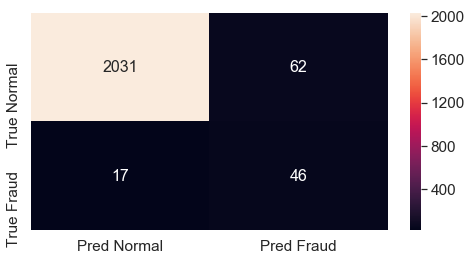

In [88]:
# Create a confusion matrix
km_cm = confusion_matrix(y_test, km_y_pred)

# Plot the confusion matrix in a figure to visualize results 
plot_confusion_matrix(km_cm)

By lowering the threshold like %93 for cases flagged as fraud, you flag more cases overall but thereby also get more false positives.

### DB scan

In [93]:
y.shape

(7184,)

In [95]:
pred_labels.shape

(7184,)

In [99]:
# Import DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.metrics import homogeneity_score, silhouette_score

# Initialize and fit the DBscan model
db = DBSCAN(eps=.9, min_samples=10, n_jobs=-1).fit(X_scaled)  ###################################

# Obtain the predicted labels and calculate number of clusters
pred_labels = db.labels_
n_clusters = len(set(pred_labels)) - (1 if -1 in y else 0)

# Print performance metrics for DBscan
print('Estimated number of clusters: %d' % n_clusters)
print("Homogeneity: %0.3f" % homogeneity_score(y, pred_labels))
print("Silhouette Coefficient: %0.3f" % silhouette_score(X_scaled, pred_labels))

Estimated number of clusters: 23
Homogeneity: 0.612
Silhouette Coefficient: 0.713


The number of clusters is much higher than with K-means. For fraud detection this is for now OK, as we are only interested in the smallest clusters, since those are considered as abnormal. 

### Assessing smallest clusters

In [102]:
pred_labels.shape

(7184,)

In [100]:
# Count observations in each cluster number
counts = np.bincount(pred_labels[pred_labels >= 0])

# Print the result
print(counts)

[3249  144 2714   55  173  119  122   98   54   15   76   15   43   25
   51   47   42   15   25   20   19   10]


In [103]:
# Sort the sample counts of the clusters and take the top 3 smallest clusters
smallest_clusters = np.argsort(counts)[:3]

# Print the results 
print("The smallest clusters are clusters:")      
print(smallest_clusters)

The smallest clusters are clusters:
[21 17  9]


In [107]:
# Print the counts of the smallest clusters only
print("Their counts are:")      
print(counts[smallest_clusters])

Their counts are:
[10 15 15]


So now we know which smallest clusters you could flag as fraud. If you were to take more of the smallest clusters, you cast your net wider and catch more fraud, but most likely also more false positives. It is up to the fraud analyst to find the right amount of cases to flag and to investigate

### Checking results

In [109]:
# Create a dataframe of the predicted cluster numbers and fraud labels
df = pd.DataFrame({'clusternr':pred_labels,'fraud':y})

# Create a condition flagging fraud for the smallest clusters 
df['predicted_fraud'] = np.where((df['clusternr']==21) | (df['clusternr']==17) | (df['clusternr']==9), 1, 0)

# Run a crosstab on the results 
print(pd.crosstab(df.fraud, df.predicted_fraud, rownames=['Actual Fraud'], colnames=['Flagged Fraud']))

Flagged Fraud     0   1
Actual Fraud           
0              6968  16
1               176  24


How does this compare to the K-means model? The good thing is: our of all flagged cases, roughly 2/3 are actually fraud! Since you only take the three smallest clusters, by definition you flag less cases of fraud, so you catch less but also have less false positives. However, you are missing quite a lot of fraud cases. Increasing the amount of smallest clusters you flag could improve that, at the cost of more false positives of course.

## Fraud detection using text

### Word search with dataframes

In [110]:
df = pd.read_csv('chapter_4/enron_emails_clean.csv')
df.head()

,Message-ID,From,To,Date,content,clean_content
0,<8345058.1075840404046.JavaMail.evans@thyme>,('advdfeedback@investools.com'),('advdfeedback@investools.com'),2002-01-29 23:20:55,INVESTools Advisory\nA Free Digest of Trusted ...,investools advisory free digest trusted invest...
1,<1512159.1075863666797.JavaMail.evans@thyme>,('richard.sanders@enron.com'),('richard.sanders@enron.com'),2000-09-20 19:07:00,----- Forwarded by Richard B Sanders/HOU/ECT o...,forwarded richard b sanders hou ect pm justin ...
2,<26118676.1075862176383.JavaMail.evans@thyme>,('m..love@enron.com'),('m..love@enron.com'),2001-10-30 16:15:17,hey you are not wearing your target purple shi...,hey wearing target purple shirt today mine wan...
3,<10369289.1075860831062.JavaMail.evans@thyme>,('leslie.milosevich@kp.org'),('leslie.milosevich@kp.org'),2002-01-30 17:54:18,Leslie Milosevich\n1042 Santa Clara Avenue\nAl...,leslie milosevich santa clara avenue alameda c...
4,<26728895.1075860815046.JavaMail.evans@thyme>,('rtwait@graphicaljazz.com'),('rtwait@graphicaljazz.com'),2002-01-30 19:36:01,"Rini Twait\n1010 E 5th Ave\nLongmont, CO 80501...",rini twait e th ave longmont co rtwait graphic...


In [111]:
df.shape

(2090, 6)

In [112]:
# Find all cleaned emails that contain 'sell enron stock'
mask = df['clean_content'].str.contains('sell enron stock', na=False)

In [114]:
# Select the data from df using the mask
df.loc[mask]

,Message-ID,From,To,Date,content,clean_content
154,<6336501.1075841154311.JavaMail.evans@thyme>,('sarah.palmer@enron.com'),('sarah.palmer@enron.com'),2002-02-01 14:53:35,\nJoint Venture: A 1997 Enron Meeting Belies O...,joint venture enron meeting belies officers cl...


### Using list of terms

In [116]:
# Create a list of terms to search for
searchfor = ['enron stock', 'sell stock', 'stock bonus', 'sell enron stock']

# Filter cleaned emails on searchfor list and select from df 
filtered_emails = (df.loc[df['clean_content'].str.contains('|'.join(searchfor), na=False)])
filtered_emails.shape

(314, 6)

By joining the search terms with the 'or' sign, i.e. `|`, you can search on a multitude of terms in your dataset very easily. 

### Creating a flag

In [117]:
# Create flag variable where the emails match the searchfor terms
df['flag'] = np.where((df['clean_content'].str.contains('|'.join(searchfor)) == True), 1, 0)

# Count the values of the flag variable
count = df['flag'].value_counts()
print(count)

0    1776
1     314
Name: flag, dtype: int64


### Removing stopwords

In [119]:
# Import nltk packages and string 
from nltk.corpus import stopwords
import string

# Define stopwords to exclude
stop = set(stopwords.words('english'))
stop.update(("to","cc","subject","http","from","sent", "ect", "u", "fwd", "www", "com"))

# Define punctuations to exclude and lemmatizer
exclude = set(string.punctuation)

### Cleaning text data

In [127]:
df = df[df.clean_content.notnull()]

In [128]:
# Import the lemmatizer from nltk
from nltk.stem.wordnet import WordNetLemmatizer
lemma = WordNetLemmatizer()

# Define word cleaning function
def clean(text, stop):
    text = text.strip()
	# Remove stopwords
    stop_free = " ".join([word for word in text.lower().split() if ((word not in stop) and (not word.isdigit()))])
	# Remove punctuations
    punc_free = ''.join(word for word in stop_free if word not in exclude)
	# Lemmatize all words
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())      
    return normalized

In [129]:
# Clean the emails in df and print results
text_clean=[]
for text in df['clean_content']:
    text_clean.append(clean(text, stop).split())    
print(text_clean)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [135]:
len(text_clean)

2086

In [134]:
text_clean[:1][0][:10]

['investools',
 'advisory',
 'free',
 'digest',
 'trusted',
 'investment',
 'advice',
 'unsubscribe',
 'free',
 'newsletter']

Now that you have cleaned your data entirely with the necessary steps, including splitting the text into words, removing stopwords and punctuations, and lemmatizing your words.

### Create dictionary and corpus

In [139]:
# Import the packages
import gensim
from gensim import corpora

# Define the dictionary
dictionary = corpora.Dictionary(text_clean)

# Define the corpus 
corpus = [dictionary.doc2bow(text) for text in text_clean]

# Print corpus and dictionary
print(dictionary)
print(corpus[:2])

Dictionary(33981 unique tokens: ['account', 'accurate', 'acquiring', 'acre', 'address']...)
[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 6), (6, 1), (7, 2), (8, 4), (9, 1), (10, 1), (11, 3), (12, 2), (13, 1), (14, 5), (15, 3), (16, 1), (17, 3), (18, 1), (19, 1), (20, 1), (21, 5), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 3), (31, 3), (32, 1), (33, 3), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 2), (42, 1), (43, 1), (44, 2), (45, 1), (46, 1), (47, 1), (48, 1), (49, 4), (50, 1), (51, 1), (52, 1), (53, 1), (54, 1), (55, 4), (56, 1), (57, 4), (58, 9), (59, 5), (60, 1), (61, 8), (62, 1), (63, 1), (64, 2), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 2), (78, 1), (79, 1), (80, 1), (81, 12), (82, 2), (83, 2), (84, 1), (85, 1), (86, 3), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 4), (96, 1), (97, 1), (98, 2), (99, 2), (100, 1), (101,

### LDA model

In [140]:
# Define the LDA model
ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=5)

# Save the topics and top 5 words
topics = ldamodel.print_topics(num_words=5)

# Print the results
for topic in topics:
    print(topic)

(0, '0.054*"image" + 0.013*"se" + 0.013*"ne" + 0.013*"sp" + 0.012*"wscc"')
(1, '0.008*"e" + 0.007*"bakernet" + 0.007*"market" + 0.006*"mail" + 0.006*"service"')
(2, '0.044*"td" + 0.033*"net" + 0.030*"money" + 0.028*"tr" + 0.026*"width"')
(3, '0.046*"enron" + 0.013*"message" + 0.011*"original" + 0.011*"hou" + 0.010*"pm"')
(4, '0.021*"enron" + 0.010*"company" + 0.006*"energy" + 0.005*"stock" + 0.005*"employee"')


 You have now successfully created your first topic model on the Enron email data. However, the print of words doesn't really give you enough information to find a topic that might lead you to signs of fraud. You'll therefore need to closely inspect the model results in order to be able to detect anything that can be related to fraud in your data

Topic 1 seems to discuss the employee share option program, and seems to point to internal conversation (with "please, may, know" etc), so this is more likely to be related to the internal accounting fraud and trading stock with insider knowledge. 

### Finding fraudsters based on topic

In [141]:
def get_topic_details(ldamodel, corpus):
    topic_details_df = pd.DataFrame()
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                topic_details_df = topic_details_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
    topic_details_df.columns = ['Dominant_Topic', '% Score', 'Topic_Keywords']
    return topic_details_df

In [142]:
# Run get_topic_details function and check the results
print(get_topic_details(ldamodel, corpus))

      Dominant_Topic  % Score  \
0                4.0   0.9486   
1                3.0   0.3729   
2                3.0   0.8979   
3                4.0   0.9935   
4                4.0   0.9934   
5                4.0   0.9934   
6                4.0   0.6020   
7                4.0   0.9934   
8                3.0   0.8718   
9                4.0   0.9934   
10               4.0   0.9935   
11               4.0   0.9240   
12               4.0   0.9945   
13               4.0   0.9506   
14               4.0   0.9506   
15               4.0   0.9934   
16               4.0   0.7503   
17               3.0   0.5102   
18               1.0   0.5662   
19               4.0   0.8777   
20               4.0   0.9933   
21               4.0   0.9941   
22               4.0   0.9933   
23               4.0   0.9934   
24               4.0   0.9227   
25               4.0   0.8954   
26               4.0   0.9931   
27               4.0   0.9686   
28               4.0   0.5371   
29        

In [143]:
# Add original text to topic details in a dataframe
contents = pd.DataFrame({'Original text': text_clean})
topic_details = pd.concat([get_topic_details(ldamodel, corpus), contents], axis=1)
topic_details.head()

,Dominant_Topic,% Score,Topic_Keywords,Original text
0,4.0,0.9486,"enron, company, energy, stock, employee, new, ...","[investools, advisory, free, digest, trusted, ..."
1,3.0,0.3729,"enron, message, original, hou, pm, please, cor...","[forwarded, richard, b, sander, hou, pm, justi..."
2,3.0,0.8978,"enron, message, original, hou, pm, please, cor...","[hey, wearing, target, purple, shirt, today, m..."
3,4.0,0.9935,"enron, company, energy, stock, employee, new, ...","[leslie, milosevich, santa, clara, avenue, ala..."
4,4.0,0.9934,"enron, company, energy, stock, employee, new, ...","[rini, twait, e, th, ave, longmont, co, rtwait..."


In [144]:
# Create flag for text highest associated with topic 3
topic_details['flag'] = np.where((topic_details['Dominant_Topic'] == 3.0), 1, 0)
print(topic_details.head())

   Dominant_Topic  % Score                                     Topic_Keywords  \
0             4.0   0.9486  enron, company, energy, stock, employee, new, ...   
1             3.0   0.3729  enron, message, original, hou, pm, please, cor...   
2             3.0   0.8978  enron, message, original, hou, pm, please, cor...   
3             4.0   0.9935  enron, company, energy, stock, employee, new, ...   
4             4.0   0.9934  enron, company, energy, stock, employee, new, ...   

                                       Original text  flag  
0  [investools, advisory, free, digest, trusted, ...     0  
1  [forwarded, richard, b, sander, hou, pm, justi...     1  
2  [hey, wearing, target, purple, shirt, today, m...     1  
3  [leslie, milosevich, santa, clara, avenue, ala...     0  
4  [rini, twait, e, th, ave, longmont, co, rtwait...     0  


you have now flagged all data that is highest associated with topic 3, that seems to cover internal conversation about enron stock options. You are a true detective.